<a href="https://colab.research.google.com/github/Vishal11590/Appplied-Programming-Lab/blob/main/Email_Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

<div align = "right"><i>VIshal, Dec - 2024</i></div>

# **Email Spam Detection** - Using Machine Learning Algorithms

**Abstract**:

Email spam is a growing issue due to more people using the internet. Spammers send fake emails for fraud, phishing, and spreading harmful links. They create fake profiles and trick people who are not aware of such scams.

To solve this, we can use machine learning to detect spam emails. Different algorithms will be tested, and the best one will be chosen based on few evaluation metrics. This helps keep email users safe from scams and fraud.


In [ ]:
import sys
import re
import pandas as pd
import numpy as np
import string
from collections import Counter, defaultdict
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Understanding the Dataset

The dataset has two columns:
1. **Message**: This column contains the text of the email.
2. **Label**: This column shows whether the message is "spam" (unwanted email) or "ham" (regular email).

## Data Loading


In [ ]:
data = pd.read_csv("/content/training_data.csv", encoding = "ISO-8859-1") # Training Data

## Dataset Information

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11298 entries, 0 to 11297
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    11298 non-null  object
 1   message  11298 non-null  object
dtypes: object(2)
memory usage: 176.7+ KB


## Missing Values / Null Values

In [ ]:
data.isnull().sum()

,0
label,0
message,0


## Duplicate Values

In [ ]:
data.duplicated().sum()

599

**Review on the Dataset**
- No Null values in the dataset.
- The dataset has 11298 entries, out of which 599 are repeated entries (it implies 11298 - 599 = 10699 unique entries).

# Data Preprocessing

In [ ]:
data.drop_duplicates(inplace = True) # Removal of Duplicate Entries

In [ ]:
# Create a binary 'spam' column: 1 for label == 'spam' else 0
data['spam'] = data['label'].apply(lambda x: 1 if x == 'spam' else 0)

In [ ]:
data.head()

,label,message,spam
0,ham,"re : a friend of mine vince , thank you very m...",0
1,ham,thank you dear dr . kaminsky : i want to thank...,0
2,ham,"flat screens hello , we are still in need of f...",0
3,ham,Hello. They are going to the village pub at 8 ...,0
4,ham,Are we doing the norm tomorrow? I finish just ...,0


# Data Visualization

## Distribution of Spam and Ham Messages

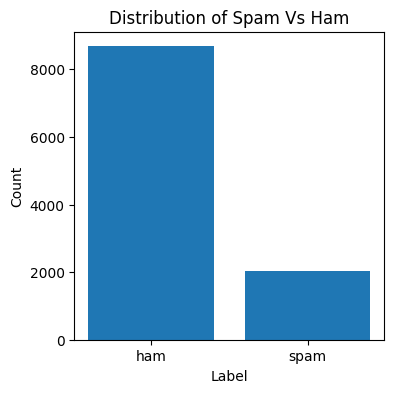

In [ ]:
counts = data['label'].value_counts()
plt.figure(figsize=(4, 4))
plt.bar(counts.index, counts.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Spam Vs Ham')
plt.show()

In [ ]:
print("Percentage of Spam Emails:", round(counts[1] / len(data) * 100, 2), "%")
print("Percentage of Ham Emails:", round(counts[0] / len(data) * 100, 2), "%")

Percentage of Spam Emails: 18.88 %
Percentage of Ham Emails: 81.12 %


## Most Used Words in Spam Messages

In [ ]:
spam_messages = data[data['spam'] == 1]['message'].copy()
spam_messages

,message
7,undelivered mail returned to sender this is th...
10,Santa Calling! Would your little ones like a c...
14,Someone U know has asked our dating service 2 ...
17,how about obtaining a fully recognized univers...
27,HOT LIVE FANTASIES call now 08707509020 Just 2...
...,...
11274,all star break special : get a flag to support...
11278,the big unit i ' ve been using your product fo...
11288,here ' s a hot play in motion homeland securit...
11291,neugierig ? - - - - 870879228701464 content - ...


In [ ]:
# Clean Messages
def clean_text(text):
  text = text.lower().translate(str.maketrans('', '', string.punctuation))
  text = re.sub(r'\b\w{1,2}\b', '', text)
  text = re.sub(r'\d+', '', text)
  stop_words = list(set(STOPWORDS))
  return [word for word in text.split() if word not in stop_words]

**Stop Words**: These are the words that do not add much meaning to a sentence. They can be ignored safely in analyzing a sentence.

In [ ]:
all_words = []
for msg in spam_messages:
  all_words.extend(clean_text(msg))
word_counts = Counter(all_words).most_common(30)
words, count = zip(*word_counts)

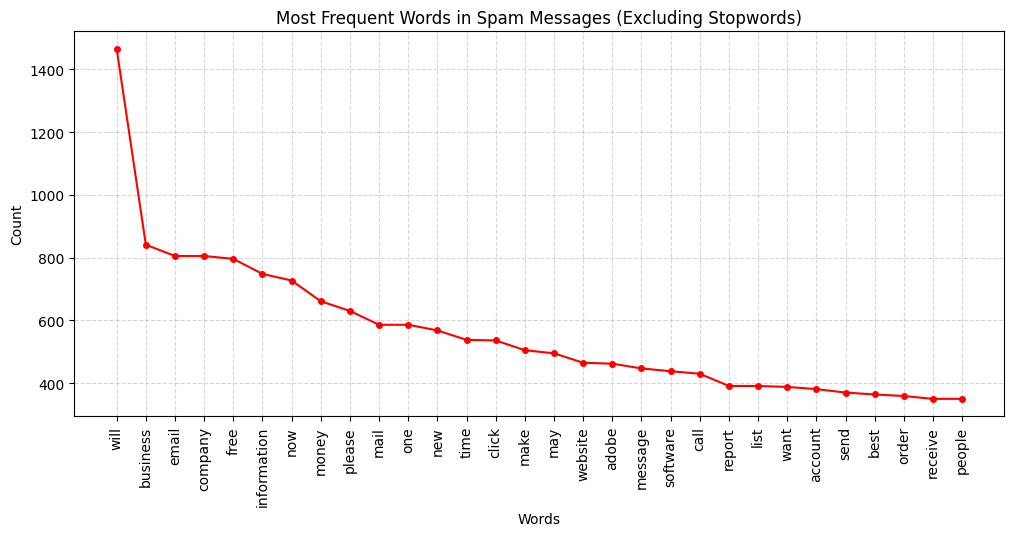

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(words, count, marker = 'o', color = 'r', ms = 4)
plt.title("Most Frequent Words in Spam Messages (Excluding Stopwords)")
plt.xlabel("Words")
plt.ylabel("Count")
plt.xticks(rotation = 90)
plt.grid(True, linestyle='--', alpha = 0.5)
plt.show()

- The above chart shows the most frequent words used in spam mails.

# Data Splitting

- It is necessary to test the model perfomance.

- Split the entire data into Training Data and Testing Data in the ratio 7:3.

In [ ]:
def split_data(data, test_size = 0.3, random_seed = None):
  if random_seed:
    np.random.seed(random_seed)
  data = data.to_numpy()
  np.random.shuffle(data)
  split_index = int(len(data) * (1 - test_size))
  return data[:split_index], data[split_index:]

data.drop(['label'], axis = 1, inplace = True)
train_data, test_data = split_data(data, test_size = 0.3, random_seed = 42)
X_train, y_train = train_data[:, 0], train_data[:, 1]
X_test, y_test = test_data[:, 0], test_data[:, 1]

# Model Evaluation

In [ ]:
def metrics(y_true, y_pred):
  cm = np.array(pd.crosstab(y_true, y_pred, rownames = ['Actual'], colnames = ['Predicted']))
  accuracy = np.mean(y_true == y_pred)
  precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
  recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
  return cm, accuracy, precision, recall

def plot_cm(cm):
  labels = [0, 1]
  print("    Confusion Matrix")
  print('='*25)
  print(f"{'Labels |':<10}{labels[0]:<10}{labels[1]:<10}")
  print('-'*25)
  print(f"{'':<2}{labels[0]:<5}{'|':<3}{cm[0,0]:<10}{cm[0,1]:<10}")
  print(f"{'':<2}{labels[1]:<5}{'|':<3}{cm[1,0]:<10}{cm[1,1]:<10}")

def print_report(train_cm = None, train_apr = None, test_cm = None, test_apr = None, train = True, test = True):
  if train:
    print("\nTrain Classification Report")
    print('='*55)
    print(f"Accuracy: {train_apr[0]:.4f} | Precision: {train_apr[1]:.4f} | Recall: {train_apr[2]:.4f}\n")
    plot_cm(train_cm)
  if test:
    print("\nTest Classification Report")
    print('='*55)
    print(f"Accuracy: {test_apr[0]:.4f} | Precision: {test_apr[1]:.4f} | Recall: {test_apr[2]:.4f}\n")
    plot_cm(test_cm)

def evaluate_model(model, X_train, X_test, y_train, y_test, report = False):
  model.fit(X_train, y_train)
  y_train_preds = model.predict(X_train)
  y_test_preds = model.predict(X_test)
  train_cm, a, p, r = metrics(y_train, y_train_preds)
  train_apr = [a, p, r]
  test_cm, a, p, r = metrics(y_test, y_test_preds)
  test_apr = [a, p, r]
  if report:
    print_report(train_cm, train_apr, test_cm, test_apr)
  return train_apr, test_apr

# Model Implementation

Few Classification Models are:

- Multinomial Naive-Bayes Classifier
- Support Vector Classifier
- K-Nearest Neighbor Classifier



In [ ]:
# Utility Function that shows the progress
def print_bar(count, total):
  percent = int(((count + 1) / total) * 100)
  bar = '#' * (percent // 2) + ' ' * (50 - percent // 2)
  sys.stdout.write(f'\r[{bar}] {percent}%')
  sys.stdout.flush()

## Text Preprocessing

Preprocessing includes eliminating unnecessary elements like numbers, short words (single and double letters), and stop words.

- *All messages in the training set are preprocessed before being used to train the model.*.

## Multinomial Naive-Bayes Classifier

**Model Parameters**: $\alpha$ - Smoothing Parameter (which helps handle words that have never appeared in the training set)
- $\alpha = 1$: Laplace Smoothing (default)
- $\alpha < 1$: Lidstone Smoothing

The key idea behind this classifier is based on Bayes Theorem with the assumption that the features (words) are conditionally independent given the class label.

---

**Bayes Theorem**

It provides a way to calculate posterior probability $P(y = c \ | \ X)$ of a class given the words $X$ of the message.

$$
P(y = c \ | \ X) = \frac{P(X \ | \ y = c) P(y = c)}{P(X)}
$$

where,

- $P(X \ | \ y = c)$ is the likelihood of observing the words $X$ given class $c$.
- $P(y = c)$ is the prior probability of class $c$.
- $P(X)$ is the marginal likelihood of observing $X$, which is a constant for all classes in classification task.

---

**Tables**: In the perspective of Binomial Classification

Class: $0$ - Ham Mail, $1$ - Spam Mail

Vocabulary is a set of all unique words (after text preprocessing) from the training set.

Let $w_1, w_2, ... w_n$ be the words in the vocabulary, $n$ is the size of the vocabulary.

$$
\text{Vocabulary} = (w_1, w_2, ... w_n)
$$

<u>Class Prior Probabilities Table</u> (`class_priors`)

| Class | Probability |
|:-:|:-:|
| $0$ | $P(y = 0)$ |
| $1$ | $P(y = 1)$ |

- $P(y = 0) = \frac{\text{Number of Ham Mails}}{\text{Total Mails}}, \ P(y = 1) = \frac{\text{Number of Spam Mails}}{\text{Total Mails}}$

<u>Word Occurences Table</u> (`class_word_counts`)

| Class/Vocabulary | $w_1$ | $w_2$ | ...... | $w_n$ |
|:---:|:---:|:---:|:---:|:---:|
| $0$ | $N_{01}$ | $N_{02}$ | ...... | $N_{0n}$ |
| $1$ | $N_{11}$ | $N_{12}$ | ...... | $N_{1n}$ |

The above tables were filled during the training phase of the model based on the training set.

---

**Calculation of $P(X \ | \ y = c)$**

Let $x_1, x_2, .. x_m$ are the words (after text preprocessing) in a message. The vector $X$ denotes the set of all these words.

$$
P(X \ | \ y = c) = P(x_1, x_2, ... x_m \ | \ y = c) = \prod_{i=1}^{m} P(x_i \ | \ y = c)
$$

where,

- $P(x_i \ | \ y = c)$ is the probability of observing the word $x_i$ given class $c$.

---

**Word Likelihood $P(x_i \ | \ y = c)$**: Multinomial Assumption

For a given class $c$, the probability of observing a word $x_i$ is estimated as:

If the word $x_i$ in the message is same as the word $w_j$ in vocabulary set,

$$
P(x_i \ | \ y = c) = \frac{N_{cj} + \alpha}{N_c + n\alpha}, \ N_c = \sum_{k=1}^{n} N_{ck}
$$

where,

- $N_{cj}$ is the word count of word $w_j$ in class $c$.
- $N_c$ is the total word count in class $c$.

Thus, the posterior probability $P(y = c \ | \ X)$ is proportional to $P(y = c)P(x_1, x_2, ... x_m \ | \ y = c)$.

---

**Prediction**

For a given message $M$, the class with the highest posterior probability will be considered as the prediction.

if $P(y = 0 \ | \ M) > P(y = 1 \ | \ M)$: $M$ is classified as Ham; else: $M$ is classified as Spam

In [ ]:
class Multinomial_NB_Classifier:
  def __init__(self, alpha = 1):
    self.alpha = alpha
    self.vocabulary = set()
    self.classes = None
    self.class_word_counts = defaultdict(lambda: defaultdict(int))
    self.class_counts = defaultdict(int)
    self.class_priors = defaultdict(float)

  def preprocess(self, text):
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\b\w{1,2}\b', '', text)
    text = re.sub(r'\d+', '', text)
    stop_words = set(STOPWORDS)
    return [word for word in text.split() if word not in stop_words]

  def fit(self, X, y):
    self.classes, self.class_counts = np.unique(y, return_counts = True)
    counter, total = 0, len(y)
    print("Training...")
    for msg, label in zip(X, y):
      print_bar(counter, total)
      counter += 1
      words = self.preprocess(msg)
      for word in words:
        self.class_word_counts[label][word] += 1
        self.vocabulary.add(word)
    print("")
    self.class_priors = {c: count / total for c, count in zip(self.classes, self.class_counts)}

  def predict(self, X):
    preds = []
    counter, total = 0, len(X)
    print("Predicting...")
    vocab_size = len(self.vocabulary)
    for msg in X:
      print_bar(counter, total)
      counter += 1
      words = self.preprocess(msg)
      class_scores = {}
      for c in self.classes:
        prob = self.class_priors[c]
        total_words = sum(self.class_word_counts[c].values())
        for word in words:
          word_count = self.class_word_counts[c].get(word, 0)
          word_prob = (word_count + self.alpha + 1e-10) / (total_words + vocab_size * self.alpha)
          prob *= word_prob
        class_scores[c] = prob
      preds.append(max(class_scores, key = class_scores.get))
    print("")
    return np.array(preds)

## Support Vector Classifier

**Model Parameters**: $\eta$ - Learning Rate, $\gamma$ - Number of Epochs

The implementation is based on a linear classifier that employs a basic version of the Perceptron learning algorithm to adjust its weights and bias through iterative updates during training.

Vocabulary is a set of all unique words (after text preprocessing) from the training set.

Let $w_1, w_2, ... w_n$ be the words in the vocabulary, $n$ is the size of the vocabulary.

$$
\text{Vocabulary} = (w_1, w_2, ... w_n)
$$

---

**Tokenization**

Let $X$ be a message with unique words (after text preprocessing) $x_1, x_2, ... x_m$, $f(x_i)$ denotes the frequency of the word $x_i$ in the message $X$.

$i_1, i_2, ... i_m$ denotes the corresponding indices of the words $x_1, x_2, ... x_m$ in the vocabulary. $i_k$ for $k = 1, 2, ... m$ is said to be valid if $x_k$ is present in vocabulary.

Let $X_{vec}$ be the corresponding transformed vector of the message $X$. The elements in the $X_{vec}$ follows:

$$
X_{vec}[\ j\ ] = \begin{cases}
f(x_k) & \text{if} \ i_k \ \text{is valid and } x_k = w_j\\
0 & \text{otherwise}   
\end{cases};\ \text{for} \ j = 1, 2, ... n
$$

---

**Linear Model**

The classifier assigns a weight to each word in the vocabulary, represented by a weight vector:

$$
\text{Weight Vector } (W) = (a_1, a_2, ... a_n)^T
$$

Linear model computes the weighted sum of features plus bias term:

$$
Z = X_{vec} \cdot W + b = \sum_{j=1}^{n} X_{vec}[ \ j\ ] \cdot a_j + b
$$

where,

- $b$ is the bias term.
- $Z$ is the linear output of the message $X$.

---

**Prediction**

The predicted label $\hat{y}$ is determined by the sign of linear output:

$$
\hat{y} = \begin{cases}
1 & Z \geq 0 \\
0 & Z < 0
\end{cases}
$$

---

**Weights and Bias Update Rule** (During Training)

The model updates weights and bias using a simple Perceptron-like update:

$$
\text{update } = \eta \cdot (y - \hat{y})
$$

where,

- $y$ is the true label.

The weight and bias updates are:

$$
a_k \leftarrow a_k + \text{update} \cdot x_k \ ; \ \text{for } k = 1, 2, ... n \\
b \leftarrow b + \text{update}
$$

In simpler terms, if the prediction is correct, nothing changes. If the prediction is wrong, the model adjusts the weights and bias in a way that moves the decision boundary closer to the correct classification.

In [ ]:
class Support_Vector_Classifier:
  def __init__(self, learning_rate = 0.01, epochs = 1000):
    self.weights = None
    self.bias = 0
    self.lr = learning_rate
    self.epochs = epochs
    self.vocabulary = None
    self.word_to_index = None

  def preprocess(self, text):
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\b\w{1,2}\b', '', text)
    text = re.sub(r'\d+', '', text)
    stop_words = set(STOPWORDS)
    return [word for word in text.split() if word not in stop_words]

  def tokenize(self, X):
    X_vectorized = np.zeros((len(X), len(self.vocabulary)))
    for i, msg in enumerate(X):
      for word in self.preprocess(msg):
        if word in self.vocabulary:
          X_vectorized[i, self.word_to_index[word]] += 1
    return X_vectorized

  def fit(self, X, y):
    self.vocabulary = set(word for msg in X for word in self.preprocess(msg))
    self.word_to_index = {word: idx for idx, word in enumerate(self.vocabulary)}
    X_vec = self.tokenize(X)
    num_samples, num_features = X_vec.shape
    self.weights = np.zeros(num_features)
    counter =  0
    print("Training...")
    for _ in range(self.epochs):
      print_bar(counter, self.epochs)
      counter += 1
      for i, x in enumerate(X_vec):
        linear_output = x @ self.weights + self.bias
        y_pred = 1 if linear_output >= 0 else 0
        update = self.lr * (y[i] - y_pred)
        self.weights += update * x
        self.bias += update
    print("")

  def predict(self, X):
    print("Predicting...")
    X_vec = self.tokenize(X)
    print_bar(0, 2)
    linear_output = X_vec @ self.weights + self.bias
    print_bar(1, 2)
    print("")
    return np.where(linear_output >= 0, 1, 0)

## K-Nearest Neighbor Classifier

**Model Parameters**: $k$ - Number of nearest neighbors to determine the output.

The KNN classifier predicts the label of a new text sample by finding the
$k$ nearest training samples based on Manhattan distance and selecting the most common label among them.

---

*The terminology related to vocabulary and tokenization are consistent with those described in the Support Vector Classifier*.

---

**Prediction**

Let $N$ be a new message sample, $X$ be the training set.

$N_{vec}$ represents the transformed vector of the message $N$, $X_{vec}$ represents the transformed matrix of the training set $X$.

$$
X_{vec} = \ (X_1, X_2, ... X_n) \ ; n \ \text{is the number of messages in }X
$$

where,

- $X_i$ is the transformed vector of the $i^{th}$ message in $X$.

The model calculates the distances between the vector representation of the new message $N_{vec}$ and all training message vectors $X_i$. It then selects the $k$ closest messages based on these distances. The most common label among these $k$ nearest messages is assigned as the predicted label for the new message $N$.

In [ ]:
class KNN_Classifier:
  def __init__(self, k = 3):
    self.k = k
    self.vocabulary = None
    self.word_to_index = None

  def preprocess(self, text):
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\b\w{1,2}\b', '', text)
    text = re.sub(r'\d+', '', text)
    stop_words = set(STOPWORDS)
    return [word for word in text.split() if word not in stop_words]

  def tokenize(self, X):
    X_vectorized = np.zeros((len(X), len(self.vocabulary)))
    for i, msg in enumerate(X):
      for word in self.preprocess(msg):
        if word in self.vocabulary:
          X_vectorized[i, self.word_to_index[word]] += 1
    return X_vectorized

  def distance(self, p1, p2):
    return np.sum(np.abs(p1 - p2))

  def fit(self, X, y):
    print("Training...")
    self.vocabulary = set(word for msg in X for word in self.preprocess(msg))
    print_bar(0, 4)
    self.word_to_index = {word: idx for idx, word in enumerate(self.vocabulary)}
    print_bar(1, 4)
    self.X_train = self.tokenize(X)
    print_bar(2, 4)
    self.y_train = np.array(y).astype(int)
    print_bar(3, 4)
    print("")

  def predict(self, X):
    X_vec = self.tokenize(X)
    preds = []
    counter, total = 0, len(X)
    print("Predicting...")
    for x in X_vec:
      print_bar(counter, total)
      counter += 1
      dists = [self.distance(x, x_train) for x_train in self.X_train]
      top_k_indices = np.argsort(dists)[:self.k]
      k_nearest = self.y_train[top_k_indices]
      most_common = np.bincount(k_nearest).argmax()
      preds.append(most_common)
    print("")
    return np.array(preds)

# Model Testing

In [ ]:
m1_accuracies, m1_precisions, m1_recalls = [[], []], [[], []], [[], []]
alphas = [0, 0.25, 0.5, 0.75, 1]
for alpha in alphas:
  train_apr, test_apr = evaluate_model(Multinomial_NB_Classifier(alpha = alpha), X_train, X_test, y_train, y_test)
  m1_accuracies[0].append(train_apr[0]), m1_accuracies[1].append(test_apr[0])
  m1_precisions[0].append(train_apr[1]), m1_precisions[1].append(test_apr[1])
  m1_recalls[0].append(train_apr[2]), m1_recalls[1].append(test_apr[2])

Training...
[##################################################] 100%
Predicting...
[##################################################] 100%
Predicting...
[##################################################] 100%
Training...
[##################################################] 100%
Predicting...
[##################################################] 100%
Predicting...
[##################################################] 100%
Training...
[##################################################] 100%
Predicting...
[##################################################] 100%
Predicting...
[##################################################] 100%
Training...
[##################################################] 100%
Predicting...
[##################################################] 100%
Predicting...
[##################################################] 100%
Training...
[##################################################] 100%
Predicting...
[##################################################] 100%
Pr

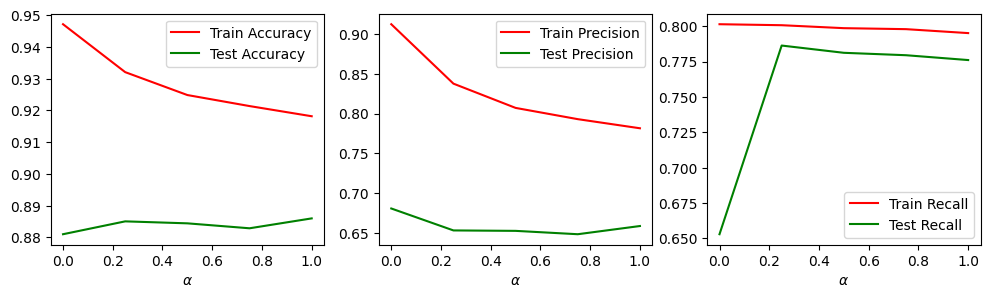

In [ ]:
%matplotlib inline

plt.figure(figsize = (12, 3))
plt.subplot(1, 3, 1)
plt.plot(alphas, m1_accuracies[0], label = 'Train Accuracy', color = 'r')
plt.plot(alphas, m1_accuracies[1], label = 'Test Accuracy', color = 'g')
plt.xlabel(r"$\alpha$")
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(alphas, m1_precisions[0], label = 'Train Precision', color = 'r')
plt.plot(alphas, m1_precisions[1], label = 'Test Precision', color = 'g')
plt.xlabel(r"$\alpha$")
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(alphas, m1_recalls[0], label = 'Train Recall', color = 'r')
plt.plot(alphas, m1_recalls[1], label = 'Test Recall', color = 'g')
plt.xlabel(r"$\alpha$")
plt.legend()
plt.show()

> Based on the results, $\alpha$ values of 0.25 and 1 are appropriate smoothing parameters for prediction.

In [ ]:
m2_accuracies, m2_precisions, m2_recalls = [[], []], [[], []], [[], []]
lrs = [0.025, 0.05, 0.1]
for lr in lrs:
  train_apr, test_apr = evaluate_model(Support_Vector_Classifier(learning_rate = lr, epochs = 500), X_train, X_test, y_train, y_test)
  m2_accuracies[0].append(train_apr[0]), m2_accuracies[1].append(test_apr[0])
  m2_precisions[0].append(train_apr[1]), m2_precisions[1].append(test_apr[1])
  m2_recalls[0].append(train_apr[2]), m2_recalls[1].append(test_apr[2])

Training...
[##################################################] 100%
Predicting...
[##################################################] 100%
Predicting...
[##################################################] 100%
Training...
[##################################################] 100%
Predicting...
[##################################################] 100%
Predicting...
[##################################################] 100%
Training...
[##################################################] 100%
Predicting...
[##################################################] 100%
Predicting...
[##################################################] 100%


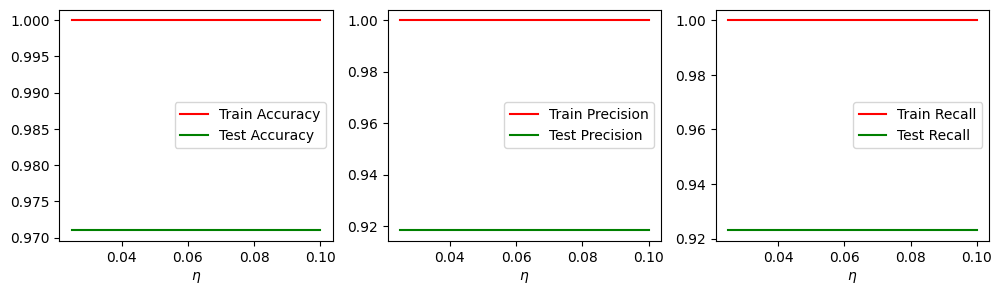

In [ ]:
%matplotlib inline

plt.figure(figsize = (12, 3))
plt.subplot(1, 3, 1)
plt.plot(lrs, m2_accuracies[0], label = 'Train Accuracy', color = 'r')
plt.plot(lrs, m2_accuracies[1], label = 'Test Accuracy', color = 'g')
plt.xlabel(r"$\eta$")
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(lrs, m2_precisions[0], label = 'Train Precision', color = 'r')
plt.plot(lrs, m2_precisions[1], label = 'Test Precision', color = 'g')
plt.xlabel(r"$\eta$")
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(lrs, m2_recalls[0], label = 'Train Recall', color = 'r')
plt.plot(lrs, m2_recalls[1], label = 'Test Recall', color = 'g')
plt.xlabel(r"$\eta$")
plt.legend()
plt.show()

> The metrics remain unchanged for different values of $\eta$, so we will use $\eta = 0.05$ for making predictions.

In [ ]:
m3_accuracies, m3_precisions, m3_recalls = [[], []], [[], []], [[], []]
ks = [1, 3, 5, 7]

# Since KNN is a lazy model, therefore, split the datasets in certain ratio
split_ratio = 5
for k in ks:
  train_apr, test_apr = evaluate_model(KNN_Classifier(k = k), X_train[::split_ratio], X_test[::4], y_train[::split_ratio], y_test[::4])
  m3_accuracies[0].append(train_apr[0]), m3_accuracies[1].append(test_apr[0])
  m3_precisions[0].append(train_apr[1]), m3_precisions[1].append(test_apr[1])
  m3_recalls[0].append(train_apr[2]), m3_recalls[1].append(test_apr[2])

Training...
[##################################################] 100%
Predicting...
[##################################################] 100%
Predicting...
[##################################################] 100%
Training...
[##################################################] 100%
Predicting...
[##################################################] 100%
Predicting...
[##################################################] 100%
Training...
[##################################################] 100%
Predicting...
[##################################################] 100%
Predicting...
[##################################################] 100%
Training...
[##################################################] 100%
Predicting...
[##################################################] 100%
Predicting...
[##################################################] 100%


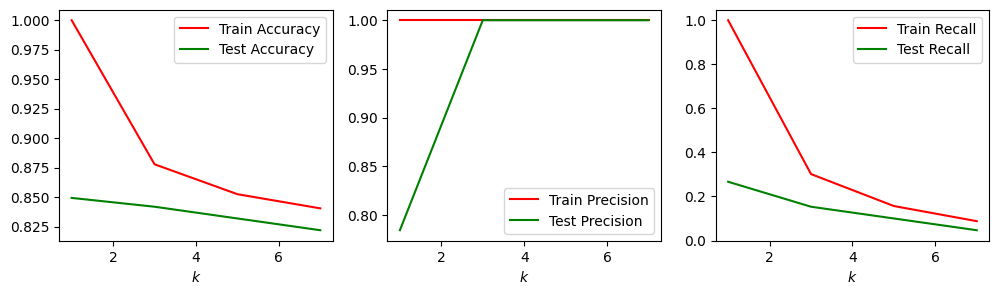

In [ ]:
%matplotlib inline

plt.figure(figsize = (12, 3))
plt.subplot(1, 3, 1)
plt.plot(ks, m3_accuracies[0], label = 'Train Accuracy', color = 'r')
plt.plot(ks, m3_accuracies[1], label = 'Test Accuracy', color = 'g')
plt.xlabel(r"$k$")
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(ks, m3_precisions[0], label = 'Train Precision', color = 'r')
plt.plot(ks, m3_precisions[1], label = 'Test Precision', color = 'g')
plt.xlabel(r"$k$")
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(ks, m3_recalls[0], label = 'Train Recall', color = 'r')
plt.plot(ks, m3_recalls[1], label = 'Test Recall', color = 'g')
plt.xlabel(r"$k$")
plt.legend()
plt.show()

> Based on results, $k = 3$ would be more suitable for making predictions.

# Model Selection and Training

According to the model testing results, the **Support Vector Classifier** is the most effective for classifying spam mails, though using a combination of all models could also be considered.

For training the model, use the entire `training_data`.

In [ ]:
model1 = Multinomial_NB_Classifier(alpha = 0.25)
model2 = Support_Vector_Classifier(learning_rate = 0.05, epochs = 500)
model3 = KNN_Classifier(k = 3)
models = [model1, model2, model3]

In [ ]:
X_train, y_train = data['message'].to_list(), data['spam'].to_list()
for model in models:
  print(f"Training {model.__class__.__name__}...")
  model.fit(X_train, y_train)
  print("")

Training Multinomial_NB_Classifier...
Training...
[##################################################] 100%

Training Support_Vector_Classifier...
Training...
[##################################################] 100%

Training KNN_Classifier...
Training...
[##################################################] 100%



# Email Spam Detection System

In [ ]:
def detect_if_spam(model, emails):
  return model.predict(emails)

# Example Usage

In [ ]:
sample_text1 = '''
Congratulations! You’ve Won a Free Gift Card!

Dear User,

You have been selected as our lucky winner! You’ve won a $1000 Amazon Gift Card. To claim your prize, simply click the link below and provide your details:

Claim Your Reward Now

Hurry! This offer is valid for the next 24 hours only.
'''

In [ ]:
m1_pred = model1.predict([sample_text1])
m2_pred = model2.predict([sample_text1])
m3_pred = model3.predict([sample_text1])

Predicting...
[##################################################] 100%
Predicting...
[##################################################] 100%
Predicting...
[##################################################] 100%


In [ ]:
print(m1_pred, m2_pred, m3_pred)

[1] [1] [0]


According to the Support Vector Classifier and the combined predictions from all models, the example above is classified as a **Spam Mail**.

In [ ]:
sample_text2 = '''
Meeting Reminder: Project Update

Hi Team,

This is a reminder about the project update meeting scheduled for Monday, 10:00 AM in Conference Room A. Please come prepared with your progress reports and any pending action items.

Let me know if you have any conflicts or need additional time for your presentations.

Looking forward to seeing everyone there!
'''

In [ ]:
m1_pred = model1.predict([sample_text2])
m2_pred = model2.predict([sample_text2])
m3_pred = model3.predict([sample_text2])

Predicting...
[##################################################] 100%
Predicting...
[##################################################] 100%
Predicting...
[##################################################] 100%


In [ ]:
print(m1_pred, m2_pred, m3_pred)

[0] [0] [0]


All the models have predicted it as a **Ham Mail**.

---